# Introdução

O Poder Judiciário brasileiro enfrenta uma crescente sobrecarga processual. Na Justiça do Trabalho, por exemplo, em 2023 foram iniciados cerca de 4,2 milhões de novos processos (aumento de 28,7\% em relação ao ano anterior) \cite{anamatra2025}. A conciliação atua como uma válvula de escape, com 12\% dos processos resolvidos via acordo, chegando a 36,5\% na Justiça do Trabalho.

Pesquisas recentes demonstram que técnicas de IA e Processamento de Linguagem Natural podem prever desfechos judiciais com acurácia elevada (cerca de 79\% e 75\% em estudos distintos). Esses resultados incentivam a aplicação de tais abordagens para identificar casos com alta probabilidade de conciliação.

Este trabalho propõe a comparação entre abordagens clássicas e Large Language Models (LLM's) para predizer a ocorrência de conciliação em processos trabalhistas no Espírito Santo. Dado um conjunto de informações processuais – incluindo dados das partes, características da causa e textos apresentados –, o objetivo é prever se o caso será resolvido por meio de conciliação ou por sentença judicial.

# Definição do problema

Devido à sobrecarga processual na Justiça do Trabalho, é essencial identificar precocemente se um processo será resolvido por conciliação ou por sentença judicial. Essa previsão auxilia na priorização e alocação dos esforços judiciais, contribuindo para uma resolução mais rápida e eficiente dos conflitos. Sendo o problema abordado prever a partir dos dados de um processo trabalhista, se a resolução ocorrerá via conciliação ou por sentença judicial.

# Descrição do conjunto de dados

A conjunto de dados trabalho reúne informações essenciais para a predição de conciliações em processos trabalhistas no Espírito Santo, organizadas em três categorias principais:

* Identificação e Classificação: Dados que permitem a organização dos casos, como o identificador único do processo e a categoria ou tipo do litígio.
* Características Econômicas e das Partes: Informações relativas ao valor da causa, à natureza das partes (pública ou privada) e à quantidade de reclamantes e reclamados, refletindo a dimensão econômica e a complexidade do processo.
* Temporalidade e Desfecho: Dados referentes às datas de ajuizamento e julgamento, além da variável binária que indica se houve conciliação (1) ou não (0), fundamentais para a análise de padrões temporais e resultados.

Para a análise realizada neste trabalho, foram utilizadas exclusivamente as seguintes características textuais: 
Vara do Trabalho, Ramo de Atividade, Classe Processual, Cidade de Origem da Petição Inicial, OAB, Assuntos, RECDA PES FÍS OU JUR, Portador de Deficiência, Segredo de Justiça, RECDA Ativa-Inativa, Ente Público ou Privado, Indicador do Processo, Documentos das Reclamadas e Documentos dos Reclamantes. 

Adicionalmente, para capturar a evolução temporal dos processos e possíveis tendências associadas às datas de julgamento, os dados foram divididos em janelas móveis baseadas no dia de julgamento. Essa estratégia permite que o modelo seja treinado e testado em intervalos de tempo distintos, sendo cada janela com 2 anos de dados totais e sendo 6 meses de diferença entre elas. 

Em cada janela, os dados foram particionados na proporção de 70\% para treino e 30\% para teste, garantindo uma avaliação robusta e representativa da performance preditiva.

In [38]:
import pandas as pd

In [39]:
df = pd.read_parquet('../data/updated_dataset.parquet.gzip')
df.head(10)

,NÚMERO DO PROCESSO,CLASSE PROCESSUAL,VARA DO TRABALHO,MAGISTRADO,ASSUNTOS,PORTADOR DEFICIÊNCIA,SEGREDO DE JUSTIÇA,RECDA ATIVA-INATIVA,RECDA PES FÍS OU JUR,OAB,...,CIDADE ORIG PET INICIAL,ENTE PUB OU PRIV,INDICADOR DO PROC,QTD RTE,QTD RDO,TIPO DE SOLUÇÃO,DATA DE JULGAMENTO,DATA DE AJUIZAMENTO,DOCUMENTOS DAS RECLAMADAS,DOCUMENTOS DOS RECLAMANTES
0,0000001-03.2016.5.17.0009,ACum - Ação de Cumprimento,VITV09 - 9ª Vara do Trabalho de Vitória ...,LUCY DE FÁTIMA CRUZ LAGO,Honorários Assistenciais; Honorários na Justiç...,N,N,S,J,"13239 - ES, 20032 - ES, 0018277 - ES, 9985 - E...",...,VITORIA - ES,Empresa Individual de Responsabilidade Limitad...,Sem Indicador do Proc,1.0,1.0,Julgados Procedente em parte,2016-10-26 19:38:52,2016-01-04 11:52:19.302,04.249.145/0001-81,32.479.073/0001-02
1,0000001-04.2019.5.17.0007,RTOrd - Ação Trabalhista - Rito Ordinário,VITV07 - 7ª Vara do Trabalho de Vitória ...,FAUSTO SIQUEIRA GAIA,Adicional de Insalubridade; Assistência Judici...,N,N,S,J,"5204 - ES, 20077 - ES",...,CARIACICA - ES,Associação Privada,Sem Indicador do Proc,1.0,1.0,Julgados Improcedente,2019-09-13 11:18:32,2019-01-03 10:58:59.914,28.141.190/0001-86,904.316.187-04
2,0000001-05.2017.5.17.0191,RTOrd - Ação Trabalhista - Rito Ordinário,MATV01 - Vara do Trabalho de São Mateus ...,EZEQUIEL ANDERSON,Anotação / Baixa / Retificação; Ausência de Ju...,N,N,S,"J, J","52308 - PR, 192953 - SP, 207753 - SP, 9985 - E...",...,SAO MATEUS - ES,"Sociedade Empresária Limitada, Sociedade de Ec...",Sem Indicador do Proc,1.0,2.0,Julgados Procedente em parte,2017-09-04 12:57:37,2017-01-02 11:11:45.636,00.277.106/0001-37|33.000.167/0001-01,019.794.547-36
3,0000001-05.2022.5.17.0005,RTSum - Ação Trabalhista - Rito Sumaríssimo,VITV05 - 5ª Vara do Trabalho de Vitória ...,FÁTIMA GOMES FERREIRA,Anotação na CTPS,N,N,S,J,10710 - ES,...,VITORIA - ES,Sociedade Empresária Limitada,Sem Indicador do Proc,1.0,1.0,Julgados Procedente,2022-05-09 16:11:26,2022-01-05 14:56:39.328,17.741.129/0001-53,075.125.376-62
4,0000001-06.2015.5.17.0181,RTOrd - Ação Trabalhista - Rito Ordinário,NVEV01 - Vara do Trabalho de Nova Venécia ...,GEOVANY CARDOSO JEVEAUX,Anotação na CTPS; Piso Salarial da Categoria /...,N,N,S,"J, J",20625 - ES,...,NOVA VENECIA - ES,"Pessoa Jurídica, Pessoa Jurídica",Sem Indicador do Proc,1.0,2.0,Conciliações,2015-03-17 18:53:28,2015-01-05 17:10:11.811,09.248.524/0001-70,136.033.447-58
5,0000001-06.2016.5.17.0008,RTOrd - Ação Trabalhista - Rito Ordinário,VITV08 - 8ª Vara do Trabalho de Vitória ...,NEY ALVARES PIMENTA FILHO,Base de Cálculo; Honorários Assistenciais; Hon...,N,N,S,"J, O","9985 - ES, 13891 - ES, 19519 - ES, 20032 - ES,...",...,VITORIA - ES,"Sociedade Empresária Limitada, Estado ou Distr...",Sem Indicador do Proc,1.0,2.0,Conciliações,2016-05-31 13:42:17,2016-01-04 11:39:11.485,39.299.359/0001-47|27.080.530/0001-43,027.857.687-79
6,0000001-07.2019.5.17.0006,RTOrd - Ação Trabalhista - Rito Ordinário,VITV06 - 6ª Vara do Trabalho de Vitória ...,GUILHERME PIVETI,Adicional de Hora Extra,N,N,S,J,"22973 - ES, 27578 - ES",...,VITORIA - ES,Sociedade Empresária Limitada,Sem Indicador do Proc,1.0,1.0,Conciliações,2019-02-19 14:23:47,2019-01-03 10:12:38.977,30.686.711/0001-22,031.527.297-07
7,0000001-08.2022.5.17.0004,ACum - Ação de Cumprimento,VITV04 - 4ª Vara do Trabalho de Vitória ...,LEONARDO GOMES DE CASTRO PEREIRA,Multa Prevista em Norma Coletiva,N,N,S,"J, O","4327 - ES, 16886 - ES, 17647 - ES, 19519 - ES",...,VITORIA - ES,"Sociedade Empresária Limitada, Estado ou Distr...",Sem Indicador do Proc,1.0,2.0,Julgados Improcedente,2022-07-04 15:33:31,2022-01-06 11:59:13.206,17.330.993/0001-62|27.080.530/0001-43,32.479.073/0001-02
8,0000001-09.2016.5.17.0007,RTOrd - Ação Trabalhista - Rito Ordinário,VITV07 - 7ª Vara do Trabalho de Vitória ...,ANTÔNIO DE CARVALHO PIRES,Anotação / Baixa / Retificação; FGTS; Honorári...,N,N,S,"O, J","0018277 - ES, 19519 - ES, 13891 - ES, 20032 - ...",...,VILA VELHA - ES,"Municípios, Sociedade Empresária Limitada",Sem Indicador do Proc,1

In [40]:
# Informações gerais sobre o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261244 entries, 0 to 14612
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   NÚMERO DO PROCESSO          261244 non-null  object        
 1   CLASSE PROCESSUAL           261244 non-null  object        
 2   VARA DO TRABALHO            261244 non-null  object        
 3   MAGISTRADO                  261244 non-null  object        
 4   ASSUNTOS                    261244 non-null  object        
 5   PORTADOR DEFICIÊNCIA        261244 non-null  object        
 6   SEGREDO DE JUSTIÇA          261244 non-null  object        
 7   RECDA ATIVA-INATIVA         261244 non-null  object        
 8   RECDA PES FÍS OU JUR        261244 non-null  object        
 9   OAB                         261244 non-null  object        
 10  VALOR DA CAUSA              261244 non-null  float64       
 11  RAMO DE ATIVIDADE           261244 non-null  

In [41]:
# Colunas presentes
df.columns

Index(['NÚMERO DO PROCESSO', 'CLASSE PROCESSUAL', 'VARA DO TRABALHO',
       'MAGISTRADO', 'ASSUNTOS', 'PORTADOR DEFICIÊNCIA', 'SEGREDO DE JUSTIÇA',
       'RECDA ATIVA-INATIVA', 'RECDA PES FÍS OU JUR', 'OAB', 'VALOR DA CAUSA',
       'RAMO DE ATIVIDADE', 'CIDADE ORIG PET INICIAL', 'ENTE PUB OU PRIV',
       'INDICADOR DO PROC', 'QTD RTE', 'QTD RDO', 'TIPO DE SOLUÇÃO',
       'DATA DE JULGAMENTO', 'DATA DE AJUIZAMENTO',
       'DOCUMENTOS DAS RECLAMADAS', 'DOCUMENTOS DOS RECLAMANTES'],
      dtype='object')

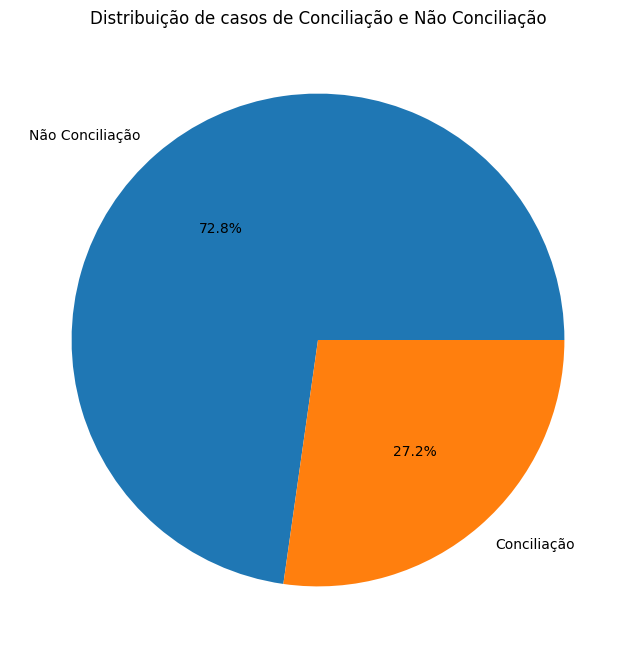

In [42]:
# Quantidade de casos de Conciliação e Não Conciliação
df['label'] = df['TIPO DE SOLUÇÃO'].apply(lambda x: 'Conciliação' if x == 'Conciliações' else 'Não Conciliação')
df['label'].value_counts()
import matplotlib.pyplot as plt

# Create pie chart
plt.figure(figsize=(10, 8))
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribuição de casos de Conciliação e Não Conciliação')
plt.ylabel('')  # Remove y-label for cleaner look
plt.show()

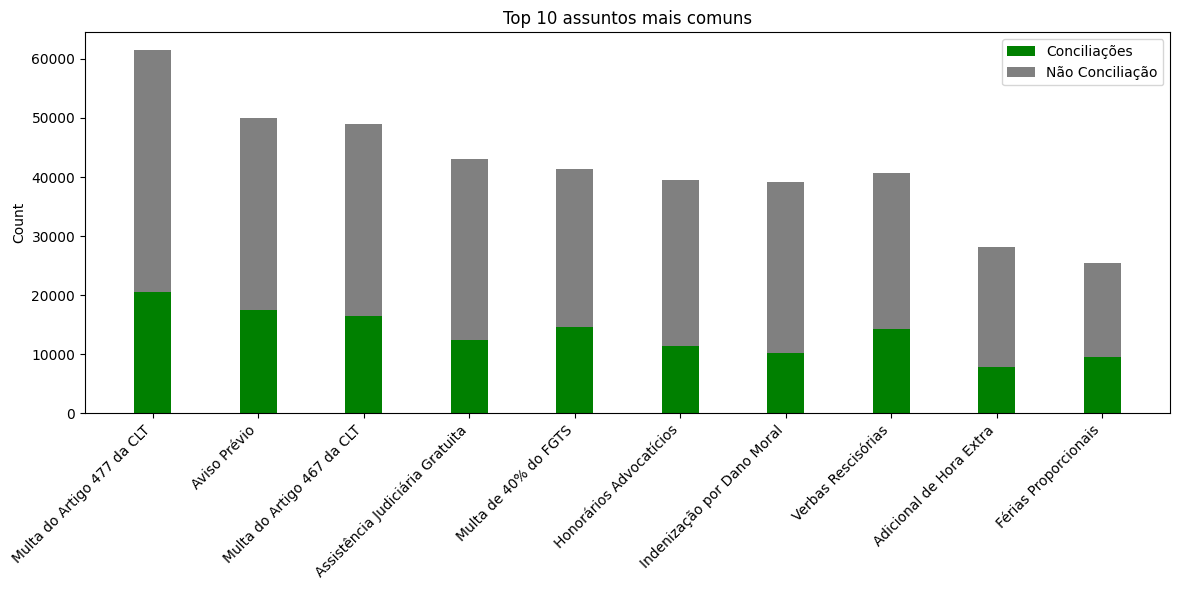

In [43]:
# Quais os assuntos mais presentes? E sua porcentagem de conciliação?
all_subjects = df['ASSUNTOS'].str.split(';').explode().str.strip()

top_10_subjects = all_subjects.value_counts().head(10)

plt.figure(figsize=(12, 6))

# For each subject, calculate total count and conciliation count
conciliation_data = []
total_data = []

for subject in top_10_subjects.index:
    # Get all processes containing this subject
    mask = df['ASSUNTOS'].str.contains(subject, na=False)
    total = mask.sum()
    
    # Get conciliation cases for this subject
    conciliation = df[mask & (df['TIPO DE SOLUÇÃO'] == 'Conciliações')].shape[0]
    
    conciliation_data.append(conciliation)
    total_data.append(total - conciliation)

# Create bar plot
bar_width = 0.35
x = range(len(top_10_subjects))

plt.bar(x, conciliation_data, bar_width, label='Conciliações', color='green')
plt.bar(x, total_data, bar_width, bottom=conciliation_data, label='Não Conciliação', color='gray')

plt.xticks(x, top_10_subjects.index, rotation=45, ha='right')
plt.title('Top 10 assuntos mais comuns')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 assuntos mais comuns')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

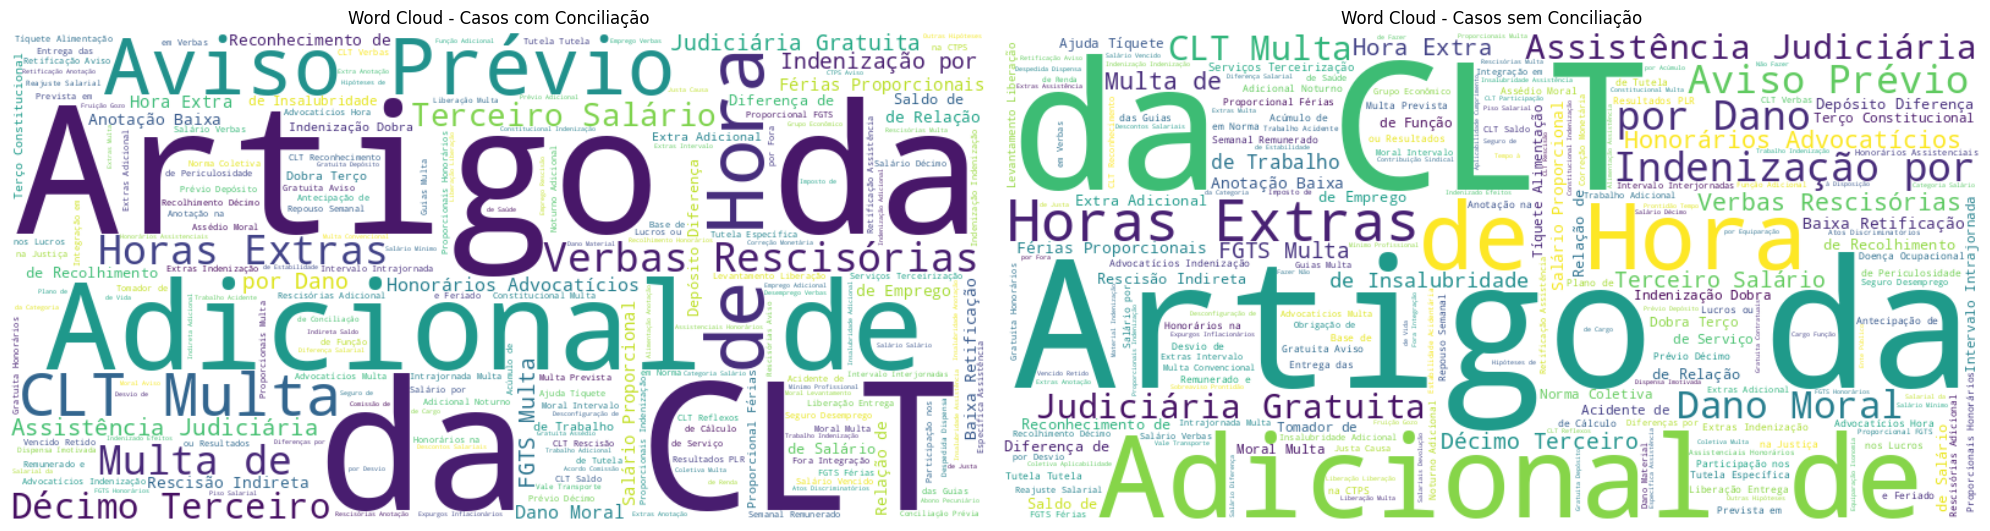

In [44]:
from wordcloud import WordCloud
# Separate texts for conciliation and non-conciliation cases
conciliation_text = ' '.join(df[df['TIPO DE SOLUÇÃO'] == 'Conciliações']['ASSUNTOS'].str.split(';').explode().str.strip())
non_conciliation_text = ' '.join(df[df['TIPO DE SOLUÇÃO'] != 'Conciliações']['ASSUNTOS'].str.split(';').explode().str.strip())

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Generate and display wordcloud for conciliation cases
wordcloud_conciliation = WordCloud(width=800, height=400, background_color='white').generate(conciliation_text)
ax1.imshow(wordcloud_conciliation, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Word Cloud - Casos com Conciliação')

# Generate and display wordcloud for non-conciliation cases
wordcloud_non_conciliation = WordCloud(width=800, height=400, background_color='white').generate(non_conciliation_text)
ax2.imshow(wordcloud_non_conciliation, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Word Cloud - Casos sem Conciliação')

plt.tight_layout()

In [45]:
import seaborn as sns

# Quais varas mais conciliam?

conciliation_by_vara = df.groupby('VARA DO TRABALHO').agg({
    'TIPO DE SOLUÇÃO': ['count', lambda x: (x == "Conciliações").sum()]
}).reset_index()

# Rename columns for clarity
conciliation_by_vara.columns = ['vara', 'total_processos', 'total_conciliados']

# Calculate percentage
conciliation_by_vara['percentual_conciliacao'] = (
    conciliation_by_vara['total_conciliados'] / conciliation_by_vara['total_processos'] * 100
)

# Sort by percentage in descending order
conciliation_by_vara = conciliation_by_vara.sort_values('percentual_conciliacao', ascending=False)
conciliation_by_vara[['vara', 'percentual_conciliacao']].head(10)

,vara,percentual_conciliacao
0,ALEV01 - Vara do Trabalho de Alegre ...,64.912281
10,NVEV01 - Vara do Trabalho de Nova Venécia ...,42.283298
12,PAALE - Posto Avançado de Alegre ...,41.911765
3,CITV02 - 2ª Vara do Trabalho de Cachoeiro ...,41.114482
11,PAAF - Posto Avançado de Afonso Cláudio ...,39.285714
2,CITV01 - 1ª Vara do Trabalho de Cachoeiro ...,39.222482
8,MATV01 - Vara do Trabalho de São Mateus ...,33.790200
5,GUAV01 - 1ª Vara do Trabalho de Guarapari ...,32.024766
1,ARAV01 - Vara do Trabalho de Aracruz ...,31.281198
13,PAMS - Posto Avançado de Mimoso do Sul ...,30.434783


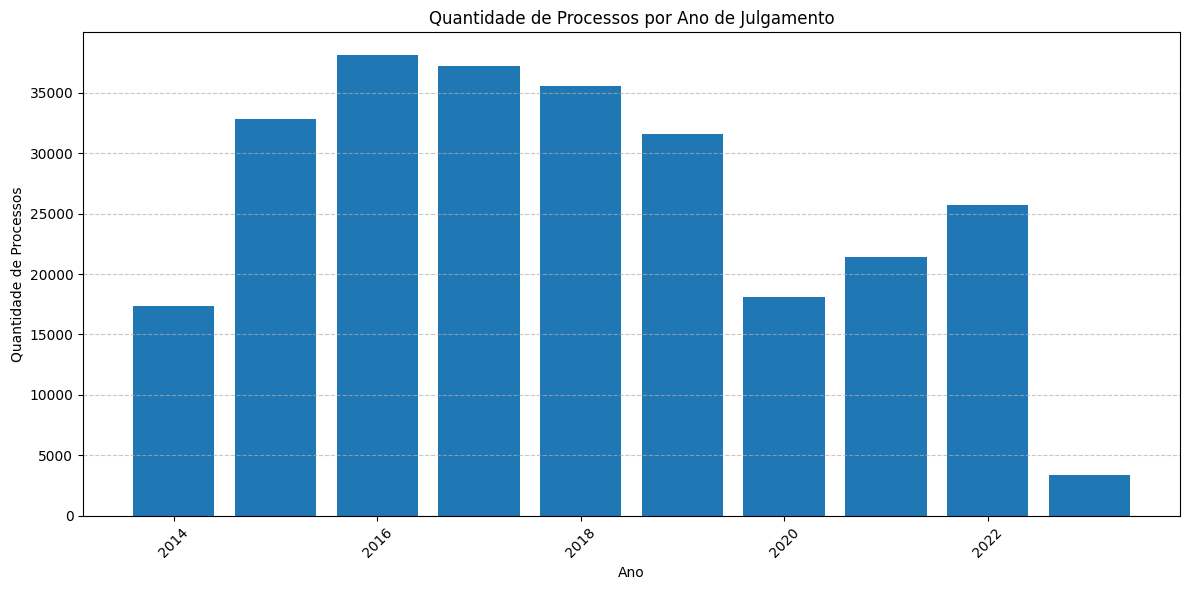

In [46]:
# Quantidade de processos por ano de data de julgamento
plt.figure(figsize=(12, 6))
df['ANO_JULGAMENTO'] = df['DATA DE JULGAMENTO'].dt.year
yearly_counts = df['ANO_JULGAMENTO'].value_counts().sort_index()

plt.bar(yearly_counts.index, yearly_counts.values)
plt.title('Quantidade de Processos por Ano de Julgamento')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Processos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Análise nas janelas móveis

In [47]:
import pandas as pd
import os

# Create empty list to store dataframes
dfs = []

# Read all window files
for i in range(20):  # Assuming there are windows from 0 to 19
    try:
        # Read the CSV file
        df = pd.read_parquet(f'../data/window_data/window_{i}/window_{i}.parquet.gzip')
        
        # Add window index as a column
        df['window_index'] = i
        
        # Append to list of dataframes
        dfs.append(df)
    except FileNotFoundError:
        print(f"File for window {i} not found, skipping...")
        continue

# Concatenate all windows
window_df = pd.concat(dfs, ignore_index=True)
window_df

File for window 19 not found, skipping...


,NÚMERO DO PROCESSO,CLASSE PROCESSUAL,VARA DO TRABALHO,MAGISTRADO,ASSUNTOS,PORTADOR DEFICIÊNCIA,SEGREDO DE JUSTIÇA,RECDA ATIVA-INATIVA,RECDA PES FÍS OU JUR,OAB,...,INDICADOR DO PROC,QTD RTE,QTD RDO,TIPO DE SOLUÇÃO,DATA DE JULGAMENTO,DATA DE AJUIZAMENTO,DOCUMENTOS DAS RECLAMADAS,DOCUMENTOS DOS RECLAMANTES,label,window_index
0,0000001-06.2015.5.17.0181,rtord - ação trabalhista - rito ordinário,nvev01 - vara trabalho nova venécia,GEOVANY CARDOSO JEVEAUX,anotação ctps; piso salarial categoria / salár...,n,n,s,"j, j",20625 - es,...,indicador proc,1.0,2.0,Conciliações,2015-03-17 18:53:28,2015-01-05 17:10:11.811,09.248.524/0001-70,136.033.447-58,1,0
1,0000001-22.2015.5.17.0014,rtord - ação trabalhista - rito ordinário,vitv14 - 14ª vara trabalho vitória,HELEN MABLE CARREÇO ALMEIDA RAMOS,multa prevista norma coletiva; norma coletiva ...,n,n,s,j,"21226 - es, 13406 - es, 23505 - es",...,indicador proc,1.0,1.0,Desistência,2015-03-26 14:11:00,2015-01-01 21:30:19.841,10.436.104/0001-05,28.164.150/0001-50,0,0
2,0000001-25.2015.5.17.0013,conpag - consignação pagamento,vitv13 - 13ª vara trabalho vitória,FAUSTO SIQUEIRA GAIA,morte,n,n,s,"f, f",56968 - mg,...,indicador proc,1.0,2.0,Extintos sem resolução de mérito,2015-02-05 06:28:24,2015-01-02 20:11:58.056,103.034.337-36,16.593.410/0001-23,0,0
3,0000001-28.2015.5.17.0012,rtord - ação trabalhista - rito ordinário,vitv12 - 12ª vara trabalho vitória,IVY D'LOURDES MALACARNE,assistência judiciária gratuita; honorários as...,n,n,s,"j, j","11011 - es, 30185 - es, 18839 - es, 17171 - es...",...,indicador proc,1.0,2.0,Desistência,2015-05-05 14:06:22,2015-01-05 12:50:56.712,17.469.701/0001-77|61.442.737/0001-59,30.978.340/0001-52,0,0
4,0000001-29.2015.5.17.0141,rtord - ação trabalhista - rito ordinário,colv01 - vara trabalho colatina,ADRIANA CORTELETTI PEREIRA CARDOSO,anotação / baixa / retificação; cargo confianç...,n,n,s,j,"9370 - es, 67356 - pr",...,indicador proc,1.0,1.0,Conciliações,2015-10-19 19:14:45,2015-01-08 10:17:08.535,79.540.670/0001-50,110.910.327-18,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989437,0001922-16.2016.5.17.0132,rtord - ação trabalhista - rito ordinário,citv02 - 2ª vara trabalho cachoeiro itapemirim,GIOVANNI ANTONIO DINIZ GUERRA,contrato suspenso,n,n,s,j,"8474 - es, 16583 - es, 7087 - es, 26185 - es, ...",...,indicador proc,1.0,1.0,Julgados Improcedente,2023-01-12 22:36:13,2016-12-06 15:51:58.663,27.193.705/0001-29,005.307.897-79,0,18
989438,0001985-58.2016.5.17.0191,rtord - ação trabalhista - rito ordinário,matv01 - vara trabalho mateus,EZEQUIEL ANDERSON,aviso prévio,n,n,s,"j, j, j, j, j","20844 - es, 229382 - sp, 13747 - es, 90070 - s...",...,indicador proc,1.0,5.0,Julgados Procedente em parte,2023-01-31 19:06:05,2016-12-15 11:50:32.428,39.403.274/0001-67|53.907.341/0001-01|15.019.5...,084.981.777-31,0,18
989439,0064100-29.2009.5.17.0008,rtord - ação trabalhista - rito ordinário,vitv08 - 8ª vara trabalho vitória,SILVANA DO EGITO BALBI,assistência judiciária gratuita; desconfiguraç...,n,n,s,j,"8390 - es, 92896 - rj, 6206 - es",...,indicador proc,1.0,1.0,Julgados Procedente,2023-02-02 12:41:14,2009-06-09 00:00:00.000,01.701.201/0001-89,804.457.997-49,0,18
989440,0124800-47.2013.5.17.0002,rtord - ação trabalhista - rito ordinário,vitv02 - 2ª vara trabalho vitória,HELEN MABLE CARREÇO ALMEIDA RAMOS,adicional hora extra; assistência judiciária g...,n,n,s,"f, j","4515 - es, 2468 - es",...,indicador proc,1.0,2.0,Julgados Procedente em parte,2023-02-13 09:45:39,2013-08-28 00:00:00.000,131.188.897-72|09.549.313/0001-78,037.519.097-02,0,18


<Figure size 1200x600 with 0 Axes>

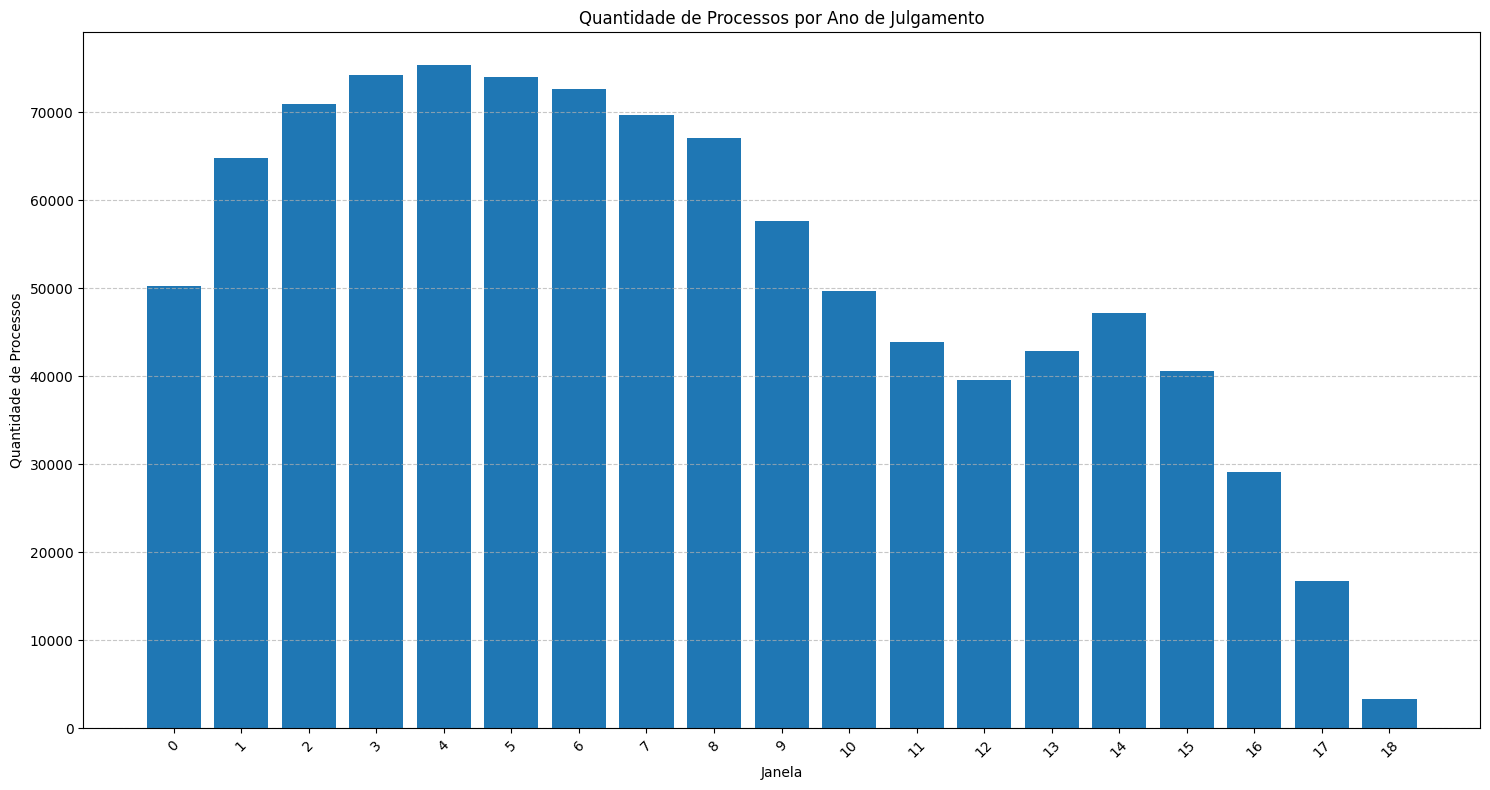

In [48]:
# Quantidade de processos por ano de data de julgamento
plt.figure(figsize=(12, 6))
df['ANO_JULGAMENTO'] = df['DATA DE JULGAMENTO'].dt.year
yearly_counts = df['ANO_JULGAMENTO'].value_counts().sort_index()

# Convert Convert window_index window_index to year to for year visualization for visualization
yearly_counts = window_df['window_index'].value_counts().sort_index()
window_df['window_index'].value_counts().sort_index()

plt.figure(figsize=(15, 8))
plt.bar(yearly_counts.index, yearly_counts.values)
plt.title('Quantidade de Processos por Ano de Julgamento')
plt.xlabel('Janela')
plt.ylabel('Quantidade de Processos')
plt.xticks(yearly_counts.index, yearly_counts.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [49]:
# Quais as datas para cada janela?
# Group data to show start and end dates for each window
window_dates = window_df.groupby('window_index').agg({
    'DATA DE JULGAMENTO': ['min', 'max', 'count']
}).reset_index()

window_dates.columns = ['Janela', 'Data de Início', 'Data de Fim', 'Quantidade de Processos']
print("Datas para cada janela:")
print(window_dates.to_string(index=False))

Datas para cada janela:
 Janela      Data de Início         Data de Fim  Quantidade de Processos
      0 2014-01-06 22:40:55 2016-01-06 17:21:56                    50191
      1 2014-07-06 23:52:34 2016-07-06 21:34:37                    64740
      2 2015-01-06 22:44:27 2017-01-06 20:48:06                    70906
      3 2015-07-06 23:49:44 2017-07-06 22:11:41                    74254
      4 2016-01-06 22:43:23 2018-01-06 16:40:10                    75299
      5 2016-07-06 22:40:57 2018-07-06 18:11:55                    74010
      6 2017-01-06 22:41:12 2019-01-06 17:18:07                    72673
      7 2017-07-06 23:34:40 2019-07-06 19:23:47                    69700
      8 2018-01-07 18:36:10 2020-01-06 18:11:36                    67103
      9 2018-07-07 15:03:33 2020-07-06 20:55:08                    57664
     10 2019-01-07 08:43:30 2021-01-06 18:21:32                    49665
     11 2019-07-07 09:41:20 2021-07-06 20:36:23                    43841
     12 2020-01-07 09:43:30

# Metodologia

A metodologia utilizada para prever conciliações combina técnicas tradicionais de Processamento de Linguagem Natural (PLN) com ferramentas baseadas em Large Language Models (LLMs). Essa abordagem integrada busca unir o conhecimento prévio e características específicas do domínio jurídico, capturadas por meio de features manuais e modelos estatísticos, à capacidade dos modelos de linguagem pré-treinados de reconhecer nuances semânticas e contextuais complexas. Inicialmente, técnicas clássicas serviram como baseline comparativa aos modelos de LLM. 

O pré-processamento dos dados envolveu etapas como remoção de entradas com valores nulos e duplicatas, conversão para letras minúsculas, tokenização dos textos e exclusão de stopwords utilizando a biblioteca NLTK, garantindo maior qualidade aos dados. Para a divisão dos dados, adotou-se uma estratégia de janelas móveis com duração de dois anos e avanços semestrais, resultando em 19 janelas entre 2014 e 2023. Cada janela foi dividida em conjuntos de treino e teste na proporção 70/30.

A metodologia clássica utilizou target encoding com suavização para reduzir riscos de overfitting, especialmente em categorias de baixa frequência, seguido do treinamento de modelos de Regressão Logística, Random Forest e Gradient Boosting, avaliados por métricas como acurácia, precisão, recall e F1-score. 

Já a abordagem com LLM dividiu-se em duas técnicas principais: na primeira, foram extraídos embeddings do modelo pré-treinado BERTimbau para alimentar um classificador Random Forest; na segunda, utilizou-se o framework HuggingFace Transformers, integrando tokenização, formatação para Dataset da HuggingFace e treinamento do modelo AutoModelForSequenceClassification por meio do Trainer, avaliando novamente com métricas tradicionais de desempenho.



# Pré-processamento

```import pandas as pd
import nltk
from nltk.corpus import stopwords
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
import string
import os

# Ensure the Portuguese stopwords are downloaded.
nltk.download('stopwords', quiet=True)

TIME_COL = 'DATA DE JULGAMENTO'

TARGET_COL = 'label'

NUMERICAL_COLS = [
    'VALOR DA CAUSA',
    'QTD RTE',
    'QTD RDO'
]

CATEGORICAL_COLS = [
    'VARA DO TRABALHO',
    'RAMO DE ATIVIDADE',
    'CLASSE PROCESSUAL',
    'CIDADE ORIG PET INICIAL',
    'OAB',
    'ASSUNTOS',
    'RECDA PES FÍS OU JUR',
    'PORTADOR DEFICIÊNCIA',
    'SEGREDO DE JUSTIÇA',
    'RECDA ATIVA-INATIVA',
    'ENTE PUB OU PRIV',
    'INDICADOR DO PROC',
    'DOCUMENTOS DAS RECLAMADAS',
    'DOCUMENTOS DOS RECLAMANTES'
]

COL_DELIMITERS = {'OAB':', ',
                'ASSUNTOS': '; ',
                'ENTE PUB OU PRIV': ', ',
                'INDICADOR DO PROC': ', ',
                'DOCUMENTOS DAS RECLAMADAS': '|',
                'DOCUMENTOS DOS RECLAMANTES':'|'}

def load_dataset(path):
    print("Loading dataset from", path)
    df = pd.read_parquet(path)
    
    df.drop_duplicates(subset=['NÚMERO DO PROCESSO'], keep='last', ignore_index=True, inplace=True)
    # df = df.sample(100, random_state=42) # Test 
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['label'] = df['TIPO DE SOLUÇÃO'].apply(lambda x: 1 if x == 'Conciliações' else 0)
    
    for col in CATEGORICAL_COLS:
        print(f"Processing column: {col}")
        df = preprocess_text_column(df, col)
    
    return df

def preprocess_text(text):
    """
    Preprocess a given text by lowercasing, removing punctuation, and filtering out Portuguese stopwords.
    
    Parameters:
    - text: str, the input text.
    
    Returns:
    - A string with the processed text.
    """
    # Convert text to lowercase.
    text = text.lower()
    # Tokenize the text (here using a simple whitespace split).
    tokens = text.split()
    # Remove Portuguese stopwords.
    stop_words = set(stopwords.words('portuguese'))
    tokens = [word for word in tokens if word not in stop_words]
    # Rejoin tokens into a single string.
    return ' '.join(tokens)

def preprocess_text_column(df, text_col, new_col=None):
    """
    Apply text preprocessing to a specific column in a DataFrame.
    If new_col is provided, the preprocessed text will be stored in that column;
    otherwise, it will overwrite the original column.
    
    Parameters:
    - df: pandas DataFrame.
    - text_col: str, name of the column containing text.
    - new_col: str, name of the column to store processed text (if None, overwrites text_col).
    
    Returns:
    - DataFrame with the text preprocessed in the specified column.
    """
    if new_col is None:
        new_col = text_col
    df[new_col] = df[text_col].astype(str).apply(preprocess_text)
    return df

def create_rolling_windows(df, date_col, window_size, window_step):
    """
    Split the DataFrame into rolling windows based on a datetime column.
    The window size and step are given as numbers interpreted as years and months, respectively.
    
    Parameters:
    - df: pandas DataFrame that contains a datetime column specified by date_col.
    - date_col: string, name of the datetime column.
    - window_size: integer, window size in years.
    - window_step: integer, step between windows in months.
    
    Returns:
    - List of DataFrame slices corresponding to each rolling window.
    """
    # Ensure the date_col is datetime type.
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    
    window_size_delta = relativedelta(years=window_size)
    window_step_delta = relativedelta(months=window_step)
    
    windows = []
    start_date = df[date_col].min()
    max_date = df[date_col].max()
    
    # Create windows until the start_date goes beyond the maximum date.
    while start_date <= max_date:
        end_date = start_date + window_size_delta
        window_df = df[(df[date_col] >= start_date) & (df[date_col] < end_date)]
        if not window_df.empty:
            windows.append(window_df)
        start_date = start_date + window_step_delta
    
    return windows```

In [50]:
df_preprocessed = pd.read_parquet('../data/updated_dataset_preprocessed.parquet.gzip')
df_preprocessed

,NÚMERO DO PROCESSO,CLASSE PROCESSUAL,VARA DO TRABALHO,MAGISTRADO,ASSUNTOS,PORTADOR DEFICIÊNCIA,SEGREDO DE JUSTIÇA,RECDA ATIVA-INATIVA,RECDA PES FÍS OU JUR,OAB,...,ENTE PUB OU PRIV,INDICADOR DO PROC,QTD RTE,QTD RDO,TIPO DE SOLUÇÃO,DATA DE JULGAMENTO,DATA DE AJUIZAMENTO,DOCUMENTOS DAS RECLAMADAS,DOCUMENTOS DOS RECLAMANTES,label
0,0000001-03.2016.5.17.0009,acum - ação cumprimento,vitv09 - 9ª vara trabalho vitória,LUCY DE FÁTIMA CRUZ LAGO,honorários assistenciais; honorários justiça t...,n,n,s,j,"13239 - es, 20032 - es, 0018277 - es, 9985 - e...",...,empresa individual responsabilidade limitada (...,indicador proc,1.0,1.0,Julgados Procedente em parte,2016-10-26 19:38:52,2016-01-04 11:52:19.302,04.249.145/0001-81,32.479.073/0001-02,0
1,0000001-04.2019.5.17.0007,rtord - ação trabalhista - rito ordinário,vitv07 - 7ª vara trabalho vitória,FAUSTO SIQUEIRA GAIA,adicional insalubridade; assistência judiciári...,n,n,s,j,"5204 - es, 20077 - es",...,associação privada,indicador proc,1.0,1.0,Julgados Improcedente,2019-09-13 11:18:32,2019-01-03 10:58:59.914,28.141.190/0001-86,904.316.187-04,0
2,0000001-05.2017.5.17.0191,rtord - ação trabalhista - rito ordinário,matv01 - vara trabalho mateus,EZEQUIEL ANDERSON,anotação / baixa / retificação; ausência justi...,n,n,s,"j, j","52308 - pr, 192953 - sp, 207753 - sp, 9985 - e...",...,"sociedade empresária limitada, sociedade econo...",indicador proc,1.0,2.0,Julgados Procedente em parte,2017-09-04 12:57:37,2017-01-02 11:11:45.636,00.277.106/0001-37|33.000.167/0001-01,019.794.547-36,0
3,0000001-05.2022.5.17.0005,rtsum - ação trabalhista - rito sumaríssimo,vitv05 - 5ª vara trabalho vitória,FÁTIMA GOMES FERREIRA,anotação ctps,n,n,s,j,10710 - es,...,sociedade empresária limitada,indicador proc,1.0,1.0,Julgados Procedente,2022-05-09 16:11:26,2022-01-05 14:56:39.328,17.741.129/0001-53,075.125.376-62,0
4,0000001-06.2015.5.17.0181,rtord - ação trabalhista - rito ordinário,nvev01 - vara trabalho nova venécia,GEOVANY CARDOSO JEVEAUX,anotação ctps; piso salarial categoria / salár...,n,n,s,"j, j",20625 - es,...,"pessoa jurídica, pessoa jurídica",indicador proc,1.0,2.0,Conciliações,2015-03-17 18:53:28,2015-01-05 17:10:11.811,09.248.524/0001-70,136.033.447-58,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261239,0124800-47.2013.5.17.0002,rtord - ação trabalhista - rito ordinário,vitv02 - 2ª vara trabalho vitória,HELEN MABLE CARREÇO ALMEIDA RAMOS,adicional hora extra; assistência judiciária g...,n,n,s,"f, j","4515 - es, 2468 - es",...,"pessoa física, sociedade empresária limitada",indicador proc,1.0,2.0,Julgados Procedente em parte,2023-02-13 09:45:39,2013-08-28 00:00:00.000,131.188.897-72|09.549.313/0001-78,037.519.097-02,0
261240,0133500-12.2013.5.17.0002,rtord - ação trabalhista - rito ordinário,vitv02 - 2ª vara trabalho vitória,LUÍS EDUARDO COUTO DE CASADO LIMA,adicional hora extra; assistência judiciária g...,n,n,s,j,"31676 - es, 17327 - es, 169760 - sp, 21262 - e...",...,sociedade anônima fechada,acidente trabalho,1.0,1.0,Conciliações,2022-10-17 11:07:07,2013-09-11 00:00:00.000,60.701.190/0001-04,031.654.457-45,1
261241,0133800-72.2012.5.17.0013,rtord - ação trabalhista - rito ordinário,vitv13 - 13ª vara trabalho vitória,ROQUE MESSIAS CALSONI,complementação benefício previdenciário,n,n,s,"j, j","61051 - pr, 12288 - es, 52308 - pr, 20283 - rj...",...,"fundação privada, sociedade economia mista",idoso,3.0,2.0,Julgados Improcedente,2022-08-31 17:26:57,2012-10-04 00:00:00.000,34.053.942/0001-50|33.000.167/0001-01,002.643.504-72|068.793.927-50|449.982.367-68,0
261242,0148200-04.2006.5.17.0013,rtord - ação trabalhista - rito ordinário,vitv13 - 13ª vara trabalho vitória,ROQUE MESSIAS CALSONI,obrigação dar,n,n,s,j,"10059 - es, 15628 - es",...,empresa pública,indicador proc,1.0,1.0,Julgados Procedente em parte,2022-08-31 17:26:26,2006-12-12 00:00:00.000,00.360.305/0001-04,042.779.882-53,0


## Metodologia clássica

### Target Encoder

```import pandas as pd

class TargetEncoder:
    def __init__(self, smoothing=1.0, col_delimiters=None):
        """
        Initialize the target encoder.
        
        Parameters:
        - smoothing: Smoothing parameter for target encoding.
        - delimiter: Delimiter used to separate multiple categories.
        """
        self.smoothing = smoothing
        self.col_delimiters = col_delimiters
        self.global_mean = None        # Global target mean from training data.
        self.encoding_map = {}         # Mapping for each column.
        self.fitted_columns = []       # List of columns that were fitted.

    def __return_encoding_map(self):
        return self.encoding_map
    
    def fit(self, X, target, columns):
        """
        Fit the encoder on the training data. This function calculates the 
        statistics and encoding mapping for each specified column independently.
        
        Parameters:
        - X: pandas DataFrame that includes the feature columns and target.
        - target: The name of the target column.
        - columns: A list (or a single string) of column names to encode.
        
        Returns:
        - self (fitted encoder)
        """
        if isinstance(columns, str):
            columns = [columns]
        self.fitted_columns = columns
        self.global_mean = X[target].mean()
        
        # For each column, calculate stats and the smoothed encoding mapping.
        for col in columns:
            stats = {}  # Temporary storage for count and sum of target per category for this column.
            for _, row in X.iterrows():
                val = row[col]
                t = row[target]
                # Check if the value is a multiple category entry.
                if isinstance(val, str) and col in self.col_delimiters:
                    categories = [v.strip() for v in val.split(self.col_delimiters[col])]
                else:
                    categories = [str(val).strip()]
                    
                for cat in categories:
                    if cat not in stats:
                        stats[cat] = {'count': 0, 'sum': 0.0}
                    stats[cat]['count'] += 1
                    stats[cat]['sum'] += t
            
            # Compute the smoothed encoding for each category in this column.
            self.encoding_map[col] = {}
            for cat, stat in stats.items():
                count = stat['count']
                cat_mean = stat['sum'] / count if count > 0 else 0
                self.encoding_map[col][cat] = (count * cat_mean + self.smoothing * self.global_mean) / (count + self.smoothing)
        return self

    def transform(self, X, columns=None):
        """
        Transform the dataset using the mapping learned during fit.
        Each column is processed independently, and if a category was not seen during training,
        the global mean is used as a fallback.
        
        Parameters:
        - X: pandas DataFrame to transform.
        - columns: (Optional) list of columns to transform. If not provided, the fitted columns are used.
                   
        Returns:
        - A new DataFrame with additional encoded columns.
        """
        if columns is None:
            columns = self.fitted_columns
        
        df = X.copy()
        for col in columns:
            if col not in self.encoding_map:
                raise ValueError(f"Column '{col}' was not fitted in the encoder!")
            encoded_values = []
            for _, row in df.iterrows():
                val = row[col]
                # For multiple category entries, compute the average encoding.
                if isinstance(val, str) and col in self.col_delimiters:
                    categories = [v.strip() for v in val.split(self.col_delimiters[col])]
                    encodings = [self.encoding_map[col].get(cat, self.global_mean) for cat in categories]
                    encoded = sum(encodings) / len(encodings) if encodings else self.global_mean
                else:
                    cat = str(val).strip()
                    encoded = self.encoding_map[col].get(cat, self.global_mean)
                encoded_values.append(encoded)
            df[col] = encoded_values
        return df

    def fit_transform(self, X, target, columns):
        """
        Fit the encoder on the data and then transform it.
        
        Parameters:
        - X: pandas DataFrame.
        - target: The name of the target column.
        - columns: A list (or single string) of column names to encode.
        
        Returns:
        - Transformed DataFrame with additional encoded columns.
        """
        return self.fit(X, target, columns).transform(X)
```

### Aplicação

```import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import os
import joblib

import data_preprocessing as dp
import target_encoder as te

def run_classification_on_split(X_train, X_test, y_train, y_test, random_state=42):
    """
    Train three classification models on provided train/test splits and print evaluation metrics.
    """
    # Print label distribution for train and test sets
    print("\nLabel Distribution:")
    print("Training set:")
    print(pd.Series(y_train).value_counts())
    print("\nTesting set:")
    print(pd.Series(y_test).value_counts())
    print("-" * 30)
    
    models = {
        'LogisticRegression': LogisticRegression(random_state=random_state),
        'RandomForest': RandomForestClassifier(random_state=random_state),
        'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
    }
    
    results = {}
    predictions = {}
    for name, clf in models.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        predictions[name] = y_pred
        
        # Print detailed classification report with zero_division parameter
        print(f"\nModel: {name}")
        print(classification_report(y_test, y_pred, zero_division=0))
        print("-" * 30)
        
        # Store results in dictionary with zero_division parameter
        report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
        results[name] = {
            'accuracy': report['accuracy'],
            'macro_avg_precision': report['macro avg']['precision'],
            'macro_avg_recall': report['macro avg']['recall'],
            'macro_avg_f1': report['macro avg']['f1-score'],
            'weighted_avg_precision': report['weighted avg']['precision'],
            'weighted_avg_recall': report['weighted avg']['recall'],
            'weighted_avg_f1': report['weighted avg']['f1-score']
        }
        
    return results, predictions

def save_window_data(window_num, X_train, X_test, y_train, y_test, predictions, fitted_models):
    """
    Save window data and models to corresponding directories.
    """
    # Create window directory
    window_dir = f'classical_analysis/results/window_{window_num}'
    os.makedirs(window_dir, exist_ok=True)
    
    # Save data
    X_train.to_csv(f'{window_dir}/X_train.csv', index=False)
    X_test.to_csv(f'{window_dir}/X_test.csv', index=False)
    y_train.to_csv(f'{window_dir}/y_train.csv', index=False)
    y_test.to_csv(f'{window_dir}/y_test.csv', index=False)
    
    # Save predictions for each model
    for model_name, y_pred in predictions.items():
        np.save(f'{window_dir}/y_pred_{model_name}.npy', y_pred)
    
    # Save models
    for model_name, model in fitted_models.items():
        joblib.dump(model, f'{window_dir}/{model_name}.joblib')

# -----------------------------
# Example Usage in Main
# -----------------------------
if __name__ == '__main__':
    
    
    # Load dataset (assumed to be in a parquet file).
    df = dp.load_dataset('data/updated_dataset.parquet.gzip')
    
    print("\nDataset after loading:")
    print(df.head(10))
    
    # Create rolling windows based on a date column.
    windows = dp.create_rolling_windows(df, date_col=dp.TIME_COL, window_size=2, window_step=6)
    print(f"\nCreated {len(windows)} rolling windows.")
    
    # Initialize results tracking dataframe
    results_all = []
    
    # For each rolling window, perform a train/test split and evaluate models.
    for i, window in enumerate(windows):
        print(f"\nProcessing Window {i+1} (from {window[dp.TIME_COL].min().date()} to {window[dp.TIME_COL].max().date()}):")
        
        # Print label distribution for the whole window
        print("\nWindow Label Distribution:")
        print(window[dp.TARGET_COL].value_counts())
        print(f"Total samples in window: {len(window)}")
        print("-" * 30)
        
        # Split the window into training and testing sets.
        train, test = train_test_split(window, test_size=0.3, random_state=42)
        
        # Apply target encoding: Fit on train and transform train and test.
        print("Applying Target Encoding...")
        encoder = te.TargetEncoder(col_delimiters=dp.COL_DELIMITERS)
        train_encoded = encoder.fit_transform(train, target=dp.TARGET_COL, columns=dp.CATEGORICAL_COLS)
        test_encoded = encoder.transform(test)
        
        # Define features and target.
        X_train = train_encoded[dp.CATEGORICAL_COLS]
        y_train = train_encoded[dp.TARGET_COL]
        X_test = test_encoded[dp.CATEGORICAL_COLS]
        y_test = test_encoded[dp.TARGET_COL]
        
        print(f"Evaluating models for Window {i+1}:")
        results, predictions = run_classification_on_split(X_train, X_test, y_train, y_test)
        
        # Save window data and fitted models
        fitted_models = {
            'LogisticRegression': LogisticRegression(random_state=42).fit(X_train, y_train),
            'RandomForest': RandomForestClassifier(random_state=42).fit(X_train, y_train),
            'GradientBoosting': GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
        }
        save_window_data(i+1, X_train, X_test, y_train, y_test, predictions, fitted_models)
        
        # Add window information to results
        for model_name, model_results in results.items():
            window_results = {
                'window_number': i+1,
                'start_date': window[dp.TIME_COL].min().date(),
                'end_date': window[dp.TIME_COL].max().date(),
                'model': model_name,
                **model_results
            }
            results_all.append(window_results)
        
        
    
    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results_all)
    output_path = 'classical_analysis/results/window_classification_results.csv'
    results_df.to_csv(output_path, index=False)
    print(f"\nResults saved to {output_path}")

```

## Feature Extraction com LLM

```import os
import numpy as np
import pandas as pd
import torch
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModel, set_seed
from sklearn.ensemble import RandomForestClassifier
import data_preprocessing as dp

# ----------------------------
# Hyperparameters
# ----------------------------
seed_val = 42
train_batch_size = 16
eval_batch_size = 16
set_seed(seed_val)

# ----------------------------
# Define Metrics Function
# ----------------------------
def compute_metrics_from_labels(true_labels, predictions):
    acc = accuracy_score(true_labels, predictions)
    prec = precision_score(true_labels, predictions, average='macro', zero_division=0)
    rec = recall_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

def create_results_directory(base_path="llm_analysis/results/embedding"):
    """Create the directory structure for saving results"""
    base_dir = Path(base_path)
    base_dir.mkdir(parents=True, exist_ok=True)
    return base_dir

def save_window_results(base_dir, window_index, y_test, y_pred, metrics, model):
    """Save all results for a specific window"""
    window_dir = base_dir / f"window_{window_index}"
    window_dir.mkdir(exist_ok=True)
    
    # Save labels
    pd.DataFrame({
        'true_labels': y_test,
        'predicted_labels': y_pred
    }).to_csv(window_dir / 'labels.csv', index=False)
    
    # Save metrics
    pd.DataFrame([metrics]).to_csv(window_dir / 'metrics.csv', index=False)
    
    # Save model
    joblib.dump(model, window_dir / 'random_forest_model.joblib')

if __name__ == '__main__':
    print("Loading dataset...")
    df = pd.read_parquet("data/updated_dataset_preprocessed.parquet.gzip")
    print(f"Dataset loaded with shape: {df.shape}")

    print("\nCreating rolling windows...")
    window_df = dp.create_rolling_windows(df, date_col=dp.TIME_COL, window_size=2, window_step=6)
    print(f"Created {len(window_df)} windows")

    results_list = []

    # Create results directory
    results_dir = create_results_directory()

    for window_index, window in enumerate(window_df):
        
        print(f"\nProcessing Window {window_index+1} (from {window[dp.TIME_COL].min().date()} to {window[dp.TIME_COL].max().date()}):")
        
        print("\nLoading BERT model and tokenizer...") # Recreate after each window
        model_name = "neuralmind/bert-base-portuguese-cased"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.eval()
        if torch.cuda.is_available():
            model.to("cuda")
            print("Model moved to GPU")
        print("Model loaded successfully")
    
        # Print label distribution for the whole window
        print("\nWindow Label Distribution:")
        print(window[dp.TARGET_COL].value_counts())
        print(f"Total samples in window: {len(window)}")
        print("-" * 30)
        
        # Make a copy to avoid modifying the original DataFrame
        window = window.copy()
        
        # Create a new "text" column by concatenating the categorical columns
        window["text"] = window[dp.CATEGORICAL_COLS].astype(str).apply(lambda x: " ".join(x), axis=1)
        
        # Ensure the target column exists
        if dp.TARGET_COL not in window.columns:
            raise ValueError(f"Target column '{dp.TARGET_COL}' not found in the DataFrame for window {window_index}")
        
        print(f"\nSplitting window {window_index+1} into train/test sets...")
        train_df, test_df = train_test_split(window, test_size=0.3, random_state=seed_val, shuffle=True)
        print(f"Train set size: {len(train_df)}, Test set size: {len(test_df)}")
        
        # ----------------------------
        # Tokenize the "text" column for train and test sets
        # ----------------------------
        print("\nTokenizing texts...")
        def tokenize_texts(df):
            return tokenizer(list(df["text"]), truncation=True, padding='max_length', max_length=512, return_tensors="pt")
        
        train_tokens = tokenize_texts(train_df)
        test_tokens = tokenize_texts(test_df)
        print("Tokenization completed")
        
        # Move tokens to GPU if available
        if torch.cuda.is_available():
            train_tokens = {k: v.to("cuda") for k, v in train_tokens.items()}
            test_tokens = {k: v.to("cuda") for k, v in test_tokens.items()}
            print("Tokens moved to GPU")
        
        # ----------------------------
        # Extract Embeddings Using BERT
        # ----------------------------
        print("\nExtracting BERT embeddings...")
        def get_embeddings(tokens, batch_size):
            embeddings = []
            input_ids = tokens["input_ids"]
            attention_mask = tokens["attention_mask"]
            dataset_size = input_ids.shape[0]
            with torch.no_grad():
                for i in range(0, dataset_size, batch_size):
                    batch_input_ids = input_ids[i:i+batch_size]
                    batch_attention_mask = attention_mask[i:i+batch_size]
                    outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
                    # Use the [CLS] token representation from the last hidden state
                    batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                    embeddings.append(batch_embeddings)
            embeddings = np.concatenate(embeddings, axis=0)
            return embeddings

        train_embeddings = get_embeddings(train_tokens, train_batch_size)
        print(f"Train embeddings shape: {train_embeddings.shape}")
        test_embeddings = get_embeddings(test_tokens, eval_batch_size)
        print(f"Test embeddings shape: {test_embeddings.shape}")
        
        # ----------------------------
        # Prepare Labels and Train Random Forest
        # ----------------------------
        print("\nTraining Random Forest classifier...")
        y_train = train_df[dp.TARGET_COL].values
        y_test = test_df[dp.TARGET_COL].values
        
        clf = RandomForestClassifier(random_state=seed_val)
        clf.fit(train_embeddings, y_train)
        print("Random Forest training completed")
        
        print("\nMaking predictions...")
        y_pred = clf.predict(test_embeddings)
        
        # Compute metrics
        metrics = compute_metrics_from_labels(y_test, y_pred)
        metrics["window"] = window_index
        results_list.append(metrics)
        
        # Save all results for this window
        save_window_results(results_dir, window_index, y_test, y_pred, metrics, clf)
        
        # Print metrics for current window
        print(f"\nMetrics for Window {window_index}:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")
        print("-" * 50)

    # ----------------------------
    # Save All Results to CSV
    print("\nSaving final results...")
    # ----------------------------
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_dir / "results_summary_random_forest.csv", index=False)
    print(f"Results successfully saved to {results_dir}")

```

## LLM classification

```import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    set_seed,
)

import data_preprocessing as dp

# ----------------------------
# Hyperparameters - (Inspired by https://github.com/lagefreitas/predicting-brazilian-court-decisions)
# ----------------------------
learning_rate = 2e-05
train_batch_size = 16
eval_batch_size = 16
seed_val = 42
num_epochs = 5
lr_scheduler_type = "linear"
set_seed(seed_val)

# ----------------------------
# Define Metrics Function
# ----------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    prec = precision_score(labels, predictions, average='macro', zero_division=0)
    rec = recall_score(labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(labels, predictions, average='macro', zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

def create_results_directory(base_path="llm_analysis/results/classification"):
    """Create the directory structure for saving results"""
    base_dir = Path(base_path)
    base_dir.mkdir(parents=True, exist_ok=True)
    return base_dir

def save_window_results(base_dir, window_index, metrics, trainer):
    """Save all results for a specific window"""
    window_dir = base_dir / f"window_{window_index}"
    window_dir.mkdir(exist_ok=True)
    
    # Save metrics
    pd.DataFrame([metrics]).to_csv(window_dir / 'metrics.csv', index=False)
    
    # Save model
    trainer.save_model(window_dir / 'final_model')

if __name__ == '__main__':

    # df = dp.load_dataset('data/updated_dataset.parquet.gzip')

    # df = df.sample(100, random_state=42)  # Test
    df= pd.read_parquet("data/updated_dataset_preprocessed.parquet.gzip")
    window_df = dp.create_rolling_windows(df, date_col=dp.TIME_COL, window_size=2, window_step=6)

    # ----------------------------
    # Process Each Window and Train/Evaluate the Model
    # ----------------------------
    results_list = []

    # Create results directory
    results_dir = create_results_directory()

    for window_index, window in enumerate(window_df):
        
        print(f"\nProcessing Window {window_index+1} (from {window[dp.TIME_COL].min().date()} to {window[dp.TIME_COL].max().date()}):")
        
        # ----------------------------
        # Load Pre-trained Model & Tokenizer (Recreate after each window)
        # ----------------------------
        model_name = "neuralmind/bert-base-portuguese-cased"  # Change if necessary
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        
        # Print label distribution for the whole window
        print("\nWindow Label Distribution:")
        print(window[dp.TARGET_COL].value_counts())
        print(f"Total samples in window: {len(window)}")
        print("-" * 30)
        
        # Make a copy to avoid modifying the original
        window = window.copy()
        
        # Create a new "text" column by concatenating the categorical columns
        window["text"] = window[dp.CATEGORICAL_COLS].astype(str).apply(lambda x: " ".join(x), axis=1)

        # Ensure the target column 'label' exists
        if dp.TARGET_COL not in window.columns:
            raise ValueError("Target column 'label' not found in the DataFrame for window {}".format(window_index))
        
        # Split data: 70% train, 30% test (shuffled)
        train_df, test_df = train_test_split(window, test_size=0.3, random_state=seed_val, shuffle=True)
        
        # Convert pandas DataFrames to Hugging Face Datasets
        train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
        test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))
        
        # Tokenize the datasets using the "text" column
        def tokenize_function(example):
            return tokenizer(example["text"], truncation=True, padding='max_length', max_length=512)
        
        train_dataset = train_dataset.map(tokenize_function, batched=True)
        test_dataset = test_dataset.map(tokenize_function, batched=True)
        
        # Set format for PyTorch
        train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", dp.TARGET_COL])
        test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", dp.TARGET_COL])
        
        # Define training arguments for this window
        output_dir = str(results_dir / f"window_{window_index}")
        os.makedirs(output_dir, exist_ok=True)
        
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=train_batch_size,
            per_device_eval_batch_size=eval_batch_size,
            learning_rate=learning_rate,
            evaluation_strategy="epoch",
            logging_steps=50,
            seed=seed_val,
            lr_scheduler_type=lr_scheduler_type,
            save_strategy="epoch",
            logging_dir=str(results_dir / f"window_{window_index}" / "logs")
        )
        
        # Create Trainer instance
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=compute_metrics,
        )
        
        # Train the model on the current window
        trainer.train()
        
        # Evaluate on the test set
        metrics = trainer.evaluate()
        
        metrics["window"] = window_index  # Track window identifier
        results_list.append(metrics)
        
        # Save results using the new methodology
        save_window_results(results_dir, window_index, metrics, trainer)
        
        # Print metrics for current window
        print(f"\nMetrics per Window {window_index}:")
        print(f"Accuracy: {metrics['eval_accuracy']:.4f}")
        print(f"Precision: {metrics['eval_precision']:.4f}")
        print(f"Recall: {metrics['eval_recall']:.4f}")
        print(f"F1 Score: {metrics['eval_f1']:.4f}")
        print("-" * 50)
        
    # Save final results summary
    print("\nSaving final results...")
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_dir / "results_summary_classification.csv", index=False)
    print(f"Results successfully saved to {results_dir}")

```

# Resultados

In [51]:
# Resultados metodologia classica
df_results_classic = pd.read_csv('../classical_analysis/results/window_classification_results.csv')
df_results_classic

,window_number,start_date,end_date,model,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1
0,1,2014-01-06,2016-01-06,LogisticRegression,0.710254,0.620035,0.545222,0.526211,0.665332,0.710254,0.649246
1,1,2014-01-06,2016-01-06,RandomForest,0.721809,0.649777,0.579897,0.579152,0.689913,0.721809,0.681243
2,1,2014-01-06,2016-01-06,GradientBoosting,0.724399,0.654687,0.588489,0.590801,0.694688,0.724399,0.688220
3,2,2014-07-06,2016-07-06,LogisticRegression,0.712645,0.633870,0.546526,0.525416,0.672402,0.712645,0.648414
4,2,2014-07-06,2016-07-06,RandomForest,0.726393,0.666578,0.580019,0.577168,0.698404,0.726393,0.680816
5,2,2014-07-06,2016-07-06,GradientBoosting,0.721604,0.656539,0.569306,0.561704,0.690293,0.721604,0.670939
6,3,2015-01-06,2017-01-06,LogisticRegression,0.729598,0.654327,0.556789,0.543677,0.693684,0.729598,0.671349
7,3,2015-01-06,2017-01-06,RandomForest,0.738530,0.671781,0.585444,0.586886,0.709610,0.738530,0.696595
8,3,2015-01-06,2017-01-06,GradientBoosting,0.736367,0.667181,0.580676,0.580362,0.706004,0.736367,0.692513
9,4,2015-07-06,2017-07-06,LogisticRegression,0.735467,0.656804,0.557256,0.545509,0.698926,0.735467,0.678000


In [52]:
# Resultados metodologia classica
df_results_llm_embedding = pd.read_csv('../llm_analysis/results/embedding/results_summary_random_forest.csv')
df_results_llm_embedding

,accuracy,precision,recall,f1,window
0,0.734228,0.701001,0.571788,0.561058,0
1,0.738595,0.723980,0.577750,0.568182,1
2,0.749436,0.726409,0.578692,0.572637,2
3,0.755533,0.730615,0.580029,0.575953,3
4,0.751616,0.725697,0.583779,0.580766,4
5,0.756745,0.747481,0.587237,0.584890,5
6,0.762224,0.740866,0.578933,0.575298,6
7,0.770062,0.735660,0.585727,0.587813,7
8,0.775868,0.760408,0.602635,0.610416,8
9,0.786012,0.774606,0.621284,0.635908,9


In [53]:
df_results_llm_classification = pd.read_csv('../llm_analysis/results/classification/results_summary_classification.csv')
df_results_llm_classification

,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,window
0,0.534358,0.747443,0.695012,0.697101,0.696027,57.4417,262.144,16.399,5.0,0
1,0.529723,0.750026,0.695644,0.671924,0.680482,58.2420,333.471,20.844,5.0,1
2,0.495859,0.762411,0.703646,0.687339,0.694104,63.8976,332.907,20.815,5.0,2
3,0.514933,0.761009,0.696919,0.679029,0.686308,66.8211,333.383,20.847,5.0,3
4,0.507072,0.761000,0.700868,0.678144,0.686841,67.8952,332.719,20.797,5.0,4
5,0.509124,0.767779,0.709992,0.686236,0.695403,66.5929,333.414,20.843,5.0,5
6,0.490249,0.767498,0.700881,0.685988,0.692355,65.5038,332.836,20.808,5.0,6
7,0.496399,0.777475,0.707907,0.677373,0.688729,63.0733,331.519,20.722,5.0,7
8,0.486712,0.784511,0.723047,0.689809,0.702127,60.6273,332.045,20.766,5.0,8
9,0.482486,0.783121,0.719569,0.710600,0.714745,113.0533,153.025,9.571,5.0,9


In [54]:
# 1. Selecionar apenas as colunas de interesse do modelo clássico
df_results_classic = df_results_classic[[
    "window_number",
    "model",
    "macro_avg_precision",
    "macro_avg_recall",
    "macro_avg_f1"
]]

df_results_classic['window_number'] = df_results_classic['window_number'] - 1

# 2. Renomear as colunas se quiser diferenciá-las (opcional)
df_results_classic = df_results_classic.rename(
    columns={
        "macro_avg_precision": "macro_precision",
        "macro_avg_recall": "macro_recall",
        "macro_avg_f1": "macro_f1",
        "window_number": "window"
    }
)

# 3. Fazer o merge relacionando 'window' (df1) com 'window_number' (df2)
df_results_llm_embedding = df_results_llm_embedding.rename(
    columns={
        "precision": "macro_precision",
        "recall": "macro_recall",
        "f1": "macro_f1"
    }
)

df_results_llm_classification = df_results_llm_classification.rename(
    columns={
        "eval_precision": "macro_precision",
        "eval_recall": "macro_recall",
        "eval_f1": "macro_f1"
    }
)

# 3. Fazer o merge relacionando 'window' (df1) com 'window_number' (df2)
df_results_llm_embedding['model'] = 'LLM_Embedding'
df_results_llm_classification['model'] = 'LLM_Classificiation'

df_results_llm_embedding = df_results_llm_embedding[[
    "window",
    "model",
    "macro_precision",
    "macro_recall",
    "macro_f1"
]]

df_results_llm_classification = df_results_llm_classification[[
    "window",
    "model",
    "macro_precision",
    "macro_recall",
    "macro_f1"
]]

# 4. Concatenar os resultados
df_results = pd.concat([df_results_classic, df_results_llm_embedding, df_results_llm_classification], ignore_index=True)
df_results = df_results.sort_values(
    by=['window', 'model'], 
    ascending=[True, False]
)
df_results

/tmp/ipykernel_365528/2651154930.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results_classic['window_number'] = df_results_classic['window_number'] - 1


,window,model,macro_precision,macro_recall,macro_f1
1,0,RandomForest,0.649777,0.579897,0.579152
0,0,LogisticRegression,0.620035,0.545222,0.526211
57,0,LLM_Embedding,0.701001,0.571788,0.561058
76,0,LLM_Classificiation,0.695012,0.697101,0.696027
2,0,GradientBoosting,0.654687,0.588489,0.590801
...,...,...,...,...,...
55,18,RandomForest,0.737681,0.559799,0.566242
54,18,LogisticRegression,0.822528,0.564589,0.573003
75,18,LLM_Embedding,0.826185,0.567430,0.577522
94,18,LLM_Classificiation,0.692534,0.655903,0.670277


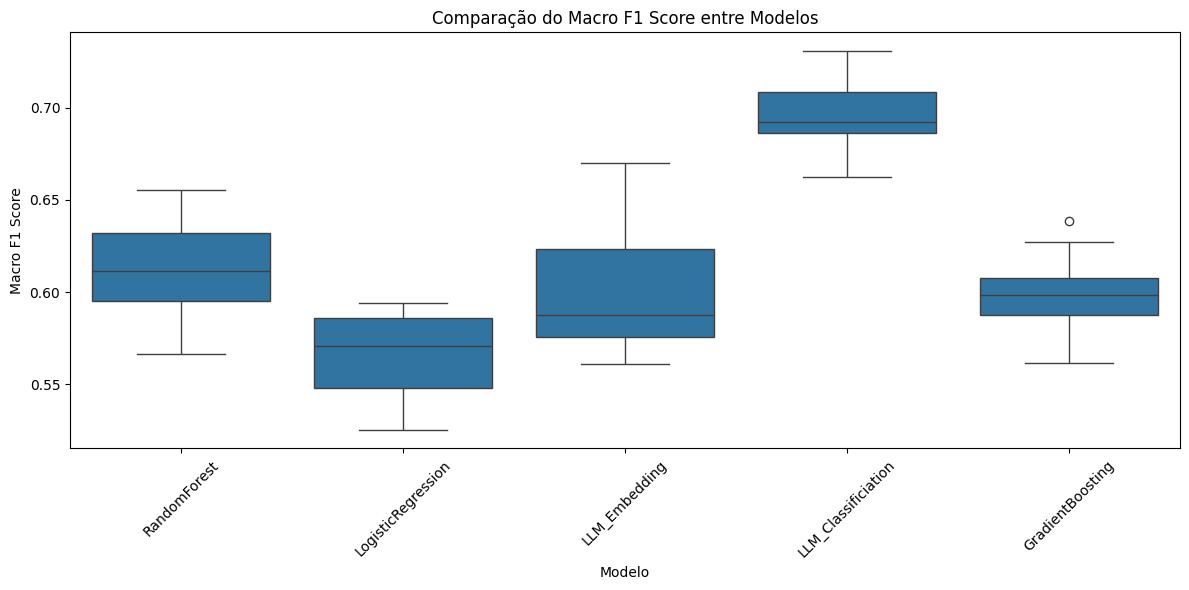

In [55]:
# Create box plot for macro F1 scores
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, x='model', y='macro_f1')

# Customize the plot
plt.title('Comparação do Macro F1 Score entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Macro F1 Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

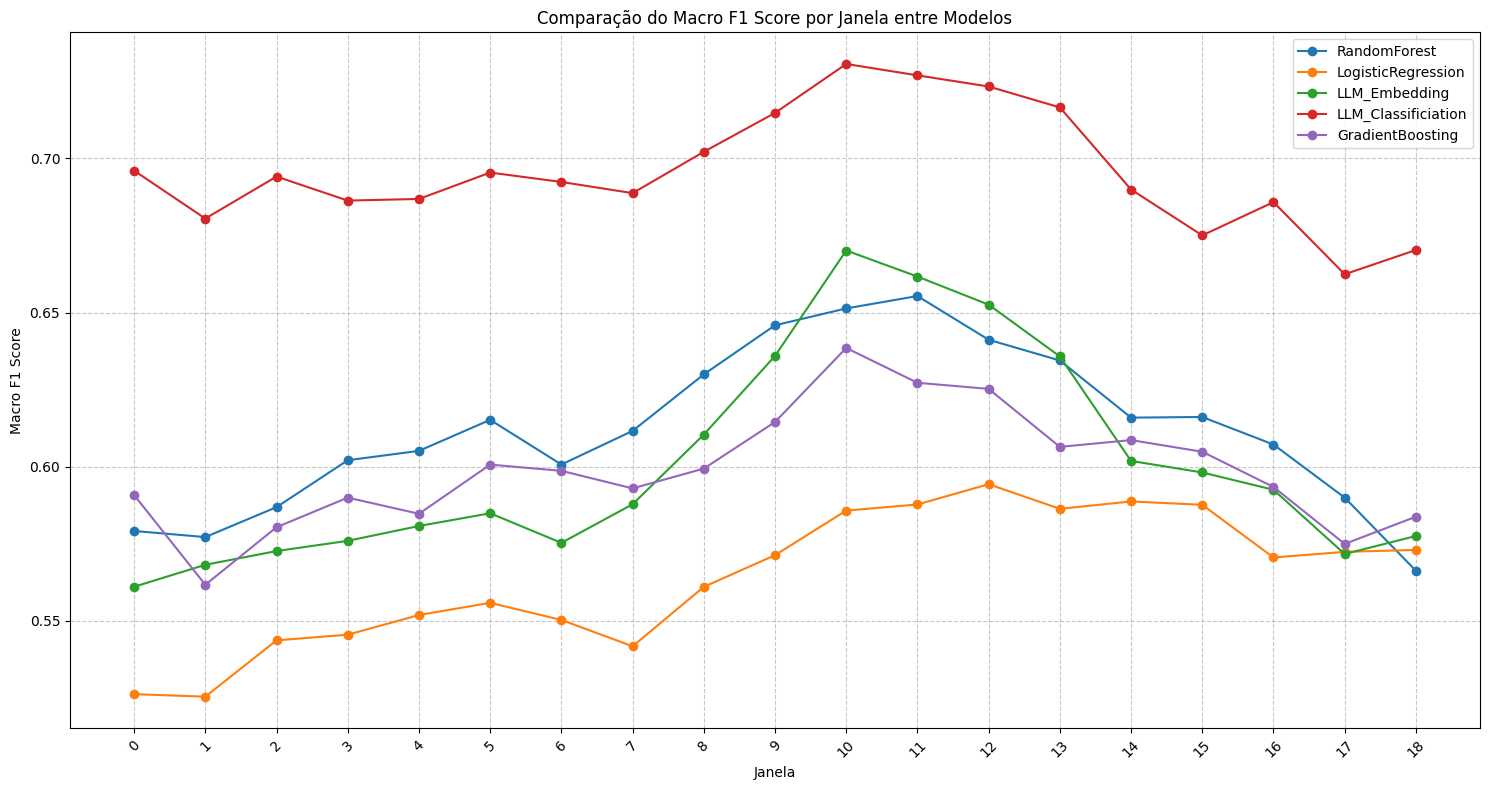

In [56]:
# Create line plot
plt.figure(figsize=(15, 8))

# Plot lines for each model
for model in df_results['model'].unique():
    model_data = df_results[df_results['model'] == model]
    plt.plot(model_data['window'], model_data['macro_f1'], marker='o', label=model)

# Customize the plot
plt.title('Comparação do Macro F1 Score por Janela entre Modelos')
plt.xlabel('Janela')
plt.ylabel('Macro F1 Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis ticks to show all windows
plt.xticks(df_results['window'].unique())

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [ ]:
# Exemplo de previsão de conciliação com o modelo final de LLM Classification na melhor janela
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import numpy as np 

# Utilizando o modelo de melhor F1 Score por janela
model_path = '../llm_analysis/results/classification/window_10/final_model'

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased") # Utilizando o tokenizer do modelo BERTimbau padrão pré-treinado em português

# Escolhendo 10 exemplos aleatórios para prever
sample_indices = np.random.randint(0, len(df_preprocessed), 10)

for idx in sample_indices:
    example_text = " ".join(df_preprocessed.loc[idx, CATEGORICAL_COLS].astype(str))
    print("-" * 80)
    print(f"Example {idx}:")
    print("Text:", example_text[:100], "...")
    
    inputs = tokenizer(example_text, truncation=True, padding='max_length', max_length=512, return_tensors="pt")
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(dim=-1)
    
    print("\nPredicted:", "Conciliation" if predictions.item() == 1 else "No Conciliation")
    print("Actual:", "Conciliation" if df_preprocessed.loc[idx, "label"] == 1 else "No Conciliation")


--------------------------------------------------------------------------------
Example 115440:
Text: vitv07 - 7ª vara trabalho vitória serviço inseminação artificial animais rtsum - ação trabalhista -  ...

Predicted: No Conciliation
Actual: No Conciliation
--------------------------------------------------------------------------------
Example 172843:
Text: vitv06 - 6ª vara trabalho vitória comércio atacadista mercadorias geral, predominância alimentos ins ...

Predicted: No Conciliation
Actual: No Conciliation
--------------------------------------------------------------------------------
Example 25016:
Text: vitv11 - 11ª vara trabalho vitória extração minério metais preciosos rtsum - ação trabalhista - rito ...

Predicted: No Conciliation
Actual: Conciliation
--------------------------------------------------------------------------------
Example 103276:
Text: citv01 - 1ª vara trabalho cachoeiro itapemirim fabricação peças acessórios sistema direção suspensão ...

Predicted: Conc

# Conclusões e discussões